In [493]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Load

In [623]:
train=pd.read_csv('train.csv')
original=pd.read_csv('final_depression_dataset_1.csv')
test=pd.read_csv('test.csv')

In [624]:
#test.head()

In [625]:
original.head(2)
# original is missing id column and test is missing depression column
train.shape,original.shape, test.shape

((140700, 20), (2556, 19), (93800, 19))

In [626]:
train.head(5)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [627]:
original['Depression'] = original['Depression'].map({"Yes": 1, "No": 0})
combo = pd.concat([train, original], ignore_index=True)

## Clean and Explore

In [628]:
df=train.copy()
len(df.columns)

20

In [500]:
#df.drop(columns=['id', 'Name'], inplace=True)


In [501]:
#df.isnull().sum()

In [502]:
#df.isnull().sum()/df.shape[0]*100

In [503]:
df.columns=df.columns.str.lower().str.replace(' ', '-').to_list()


In [504]:
# get categorical columns
cat_cols=df.columns[df.dtypes=='O'].to_list()
# get numerical columns
num_cols = [cols for cols in df.select_dtypes('number').columns if cols!= 'id' and cols!='depression']


In [505]:
len(cat_cols) , len(num_cols)

(10, 8)

In [506]:
cat_cols

['name',
 'gender',
 'city',
 'working-professional-or-student',
 'profession',
 'sleep-duration',
 'dietary-habits',
 'degree',
 'have-you-ever-had-suicidal-thoughts-?',
 'family-history-of-mental-illness']

In [507]:
# Convert the content of all colums to lower case
for col in cat_cols:
    df[col]=df[col].str.lower()


In [508]:
#df.isnull().sum()

## Handling missing value in categorical columns  
Classifying all the values having a value count of less than 100 to a different new class noise and fill the NaN values to new class missing.

In [509]:
threshold=100
for col in df.select_dtypes('object').columns:
    # fill in all NaN by 'missing'
    df[col] = df[col].fillna('missing')
    # computes the frequency of each unique value in the column, including NaN values
    # sets the value of the column to "noise" for all rows where the boolean condition (value count is less than threshold) is true.
    df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = "noise"

In [510]:
for col in num_cols:
        df[col]=df[col].fillna(0)

In [511]:
#df.isnull().sum()

In [512]:
#df.isnull().sum()/df.shape[0]*100

In [629]:
def preprocess(df):
     # Change columns titles to lower case
    df.columns=df.columns.str.lower().str.replace(' ', '-').to_list()
    # get numerical columns
    num_cols = [cols for cols in df.select_dtypes('number').columns if cols!= 'id' and cols!='depression']
   
    # get categorical columns
    cat_cols=df.columns[df.dtypes=='O'].to_list()
    # Change categorical column content to lower case
    for col in cat_cols:
        df[col]=df[col].str.lower()
    threshold=100
    for col in cat_cols:
        # fill in all NaN by 'missing'
        df[col] = df[col].fillna('missing')
        # computes the frequency of each unique value in the column, including NaN values
        # sets the value of the column to "noise" for all rows where the boolean condition (value count is less than threshold) is true.
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = "noise"
    for col in num_cols:
        df[col]=df[col].fillna(0)
    # remove name column as it does not affect the target
    cat_cols.remove('name')
    features=num_cols+cat_cols
    
    
    

    return features, df

  
    
    

In [514]:
features, df=preprocess(df)
len(features) , df.shape


(17, (140700, 20))

## Base Model

In [515]:
df.depression.value_counts(normalize=True)  # base accuracy is 82%


depression
0    0.818287
1    0.181713
Name: proportion, dtype: float64

## Split

In [516]:
from sklearn.model_selection import train_test_split

In [517]:
df.shape

(140700, 20)

In [518]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train_full.shape, df_test.shape

((112560, 20), (28140, 20))

In [519]:
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
df_train.shape, df_val.shape

((84420, 20), (28140, 20))

In [520]:
# reset index 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [521]:
y_train = df_train.depression.values
y_val = df_val.depression.values
y_test=df_test.depression.values

In [522]:
# drop target
del df_train['depression']
del df_val['depression']
del df_test['depression']

## Exploratory data analysis

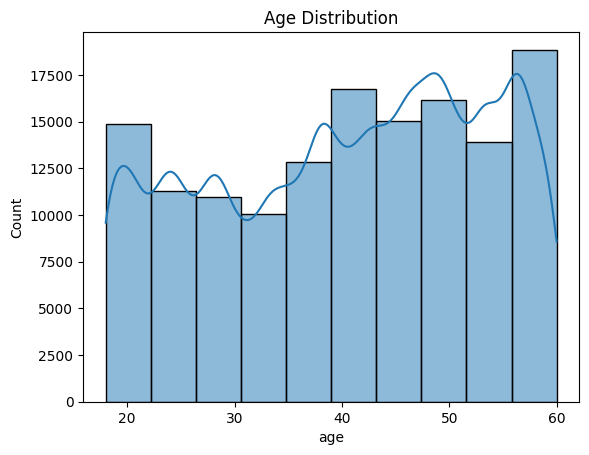

In [523]:
sns.histplot(data=df, x='age', bins=10, kde=True)
plt.title("Age Distribution")
plt.show()

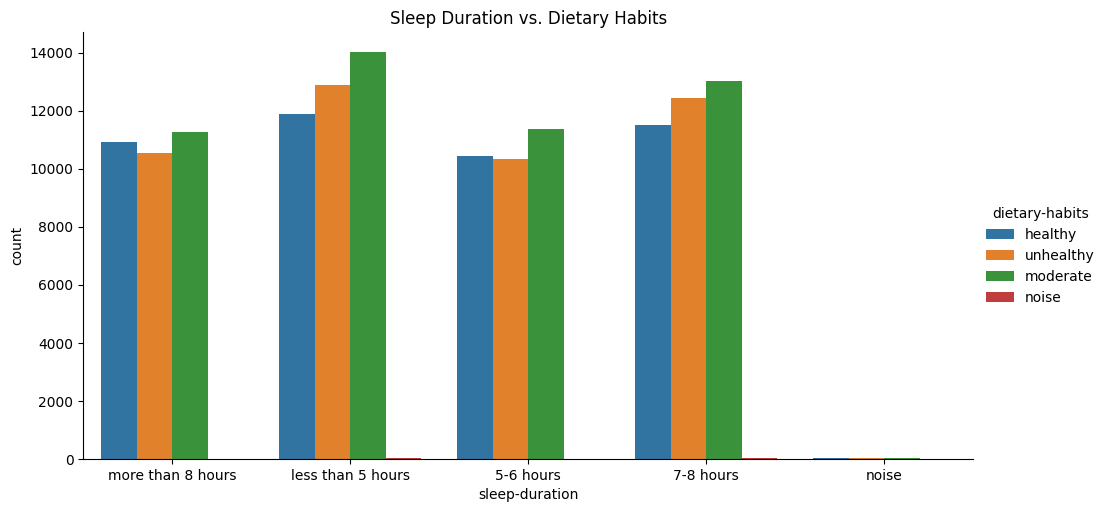

In [524]:
sns.catplot(data=df, x='sleep-duration', hue='dietary-habits', kind='count', height=5, aspect=2)
plt.title("Sleep Duration vs. Dietary Habits")
plt.show()


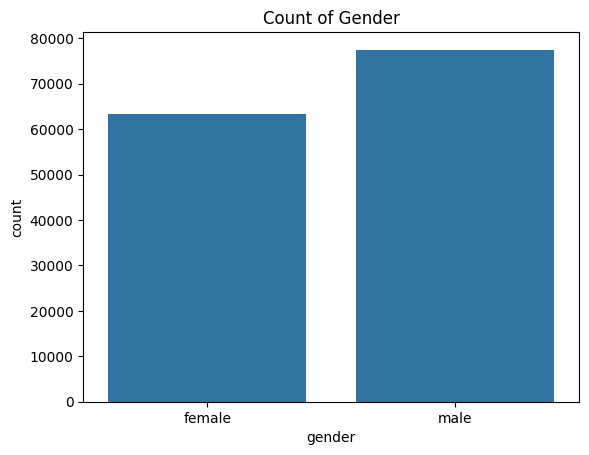

In [525]:
sns.countplot(data=df, x='gender')
plt.title("Count of Gender")
plt.show()


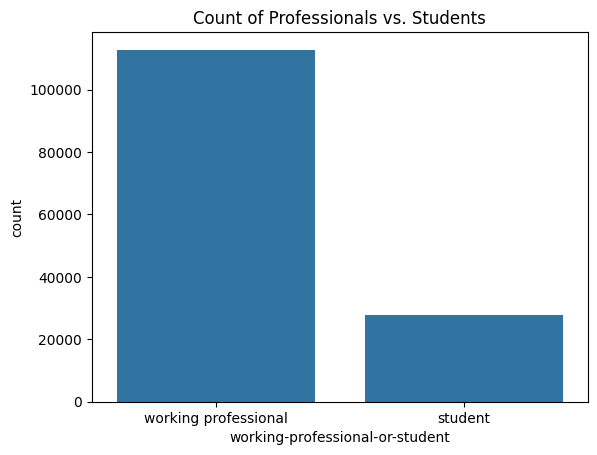

In [526]:
sns.countplot(data=df, x='working-professional-or-student')
plt.title("Count of Professionals vs. Students")
plt.show()


In [527]:
df_train_full.depression.value_counts(normalize=True)

depression
0    0.817884
1    0.182116
Name: proportion, dtype: float64

In [528]:
global_mean = df_train_full.depression.mean()
round(global_mean, 3)

np.float64(0.182)

In [529]:
df_train_full[cat_cols].nunique()

name                                     209
gender                                     2
city                                      31
working-professional-or-student            2
profession                                37
sleep-duration                             5
dietary-habits                             4
degree                                    28
have-you-ever-had-suicidal-thoughts-?      2
family-history-of-mental-illness           2
dtype: int64

In [530]:
female_mean = df_train_full[df_train_full.gender == 'female'].depression.mean()
print('gender == female:', round(female_mean, 3))

male_mean = df_train_full[df_train_full.gender == 'male'].depression.mean()
print('gender == male:  ', round(male_mean, 3))

gender == female: 0.179
gender == male:   0.184


In [531]:
female_mean / global_mean

np.float64(0.985333280875737)

In [532]:
male_mean / global_mean

np.float64(1.0119970280230686)

In [533]:
df_group = df_train_full.groupby(by='gender').depression.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean'] / global_mean
df_group

,mean,diff,risk
gender,,,
female,0.179445,-0.002671,0.985333
male,0.184301,0.002185,1.011997


In [534]:
from IPython.display import display

In [535]:
global_mean = df_train_full.depression.mean()
global_mean

np.float64(0.18211620469083156)

In [536]:
for col in cat_cols:
    df_group = df_train_full.groupby(by=col).depression.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
name,,,
aadhya,0.206070,0.023954,1.131532
aahana,0.220557,0.038441,1.211077
aakash,0.224490,0.042374,1.232673
aanchal,0.196691,0.014575,1.080031
aaradhya,0.195561,0.013445,1.073825
...,...,...,...
yashvi,0.149837,-0.032279,0.822756
yogesh,0.309434,0.127318,1.699102
yuvraj,0.166667,-0.015450,0.915167


,mean,diff,risk
gender,,,
female,0.179445,-0.002671,0.985333
male,0.184301,0.002185,1.011997


,mean,diff,risk
city,,,
agra,0.195083,0.012967,1.071200
ahmedabad,0.218030,0.035914,1.197202
bangalore,0.172903,-0.009213,0.949409
bhopal,0.238628,0.056512,1.310307
chennai,0.191841,0.009724,1.053396
delhi,0.188022,0.005906,1.032430
faridabad,0.145143,-0.036973,0.796979
ghaziabad,0.197859,0.015743,1.086444
hyderabad,0.281145,0.099029,1.543766


,mean,diff,risk
working-professional-or-student,,,
student,0.585200,0.403084,3.213335
working professional,0.081938,-0.100179,0.449919


,mean,diff,risk
profession,,,
accountant,0.068966,-0.113151,0.378690
architect,0.098271,-0.083845,0.539605
business analyst,0.056949,-0.125167,0.312709
chef,0.047826,-0.134290,0.262613
chemist,0.027197,-0.154920,0.149337
civil engineer,0.075130,-0.106987,0.412536
consultant,0.046810,-0.135306,0.257032
content writer,0.018944,-0.163173,0.104020
customer support,0.046341,-0.135775,0.254461


,mean,diff,risk
sleep-duration,,,
5-6 hours,0.165000,-0.017117,0.906013
7-8 hours,0.179899,-0.002217,0.987826
less than 5 hours,0.234377,0.052261,1.286964
more than 8 hours,0.139668,-0.042448,0.766919
noise,0.142857,-0.039259,0.784429


,mean,diff,risk
dietary-habits,,,
healthy,0.118268,-0.063848,0.649412
moderate,0.166231,-0.015886,0.912772
noise,0.450000,0.267884,2.470950
unhealthy,0.261135,0.079018,1.433890


,mean,diff,risk
degree,,,
b.arch,0.157524,-0.024592,0.864966
b.com,0.155658,-0.026458,0.854719
b.ed,0.129940,-0.052176,0.713500
b.pharm,0.117672,-0.064444,0.646137
b.tech,0.213217,0.031100,1.170772
ba,0.124664,-0.057452,0.684530
bba,0.135411,-0.046705,0.743544
bca,0.207092,0.024975,1.137140
be,0.187500,0.005384,1.029562


,mean,diff,risk
have-you-ever-had-suicidal-thoughts-?,,,
no,0.049038,-0.133079,0.269266
yes,0.318135,0.136019,1.746881


,mean,diff,risk
family-history-of-mental-illness,,,
no,0.175338,-0.006778,0.962783
yes,0.188967,0.006851,1.037618


In [537]:
from sklearn.metrics import mutual_info_score

In [538]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.depression)

df_mi = df_train_full[cat_cols].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
    
    
display(df_mi.head())
display(df_mi.tail())

,MI
profession,0.135946
working-professional-or-student,0.112467
have-you-ever-had-suicidal-thoughts-?,0.066372
degree,0.038233
name,0.015593


,MI
dietary-habits,0.011435
sleep-duration,0.004113
city,0.003955
family-history-of-mental-illness,0.000156
gender,0.000020


## Train

In [539]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import RandomForestClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer

In [540]:
lr=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
dv = DictVectorizer(sparse=False)


In [541]:
len(df_train.columns)
#df_train.head()

19

In [542]:
train_dict=df_train[features].to_dict(orient='records')
print(train_dict[0])
X_train = dv.fit_transform(train_dict)

lr.fit(X_train, y_train)

{'age': 47.0, 'academic-pressure': 0.0, 'work-pressure': 4.0, 'cgpa': 0.0, 'study-satisfaction': 0.0, 'job-satisfaction': 1.0, 'work/study-hours': 12.0, 'financial-stress': 5.0, 'gender': 'male', 'city': 'kolkata', 'working-professional-or-student': 'working professional', 'profession': 'teacher', 'sleep-duration': '7-8 hours', 'dietary-habits': 'unhealthy', 'degree': 'llb', 'have-you-ever-had-suicidal-thoughts-?': 'yes', 'family-history-of-mental-illness': 'no'}


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [543]:
## Tree models
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=15)

In [544]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- age <= 33.50
|   |--- have-you-ever-had-suicidal-thoughts-?=yes <= 0.50
|   |   |--- academic-pressure <= 3.50
|   |   |   |--- class: 0
|   |   |--- academic-pressure >  3.50
|   |   |   |--- class: 1
|   |--- have-you-ever-had-suicidal-thoughts-?=yes >  0.50
|   |   |--- academic-pressure <= 2.50
|   |   |   |--- class: 1
|   |   |--- academic-pressure >  2.50
|   |   |   |--- class: 1
|--- age >  33.50
|   |--- academic-pressure <= 2.50
|   |   |--- have-you-ever-had-suicidal-thoughts-?=yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- have-you-ever-had-suicidal-thoughts-?=yes >  0.50
|   |   |   |--- class: 0
|   |--- academic-pressure >  2.50
|   |   |--- have-you-ever-had-suicidal-thoughts-?=yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- have-you-ever-had-suicidal-thoughts-?=yes >  0.50
|   |   |   |--- class: 1



In [545]:
val_dict=df_val[features].to_dict(orient='records')
X_val=dv.transform(val_dict)
y_pred=lr.predict(X_val)

In [546]:
accuracy_score(y_val, y_pred)

0.9409737029140014

In [547]:
import time

In [548]:
def train(df, model):
    train_dict=df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    model.fit(X_train, y_train)


    return model

In [549]:
t=time.time()
t

1731271865.6795871

In [550]:
t0=time.time()
LR=train(df_train, lr)
t1=time.time()
print(t1-t0)

6.618919610977173


## Evaluate

In [551]:
def predict(X,model):
    y_pred=model.predict(X)
    return y_pred

In [552]:
val_dict=df_val[features].to_dict(orient='records')
X_val=dv.transform(val_dict)
y_pred=predict(X_val, LR)
accuracy_score(y_val, y_pred)

0.9409737029140014

## Model fine tuning

In [615]:
scores=[]
c_list=[0.045,0.05, 0.06, 0.07, 0.08,0.09,0.1,0.12, 0.2,0.3, 0.4, 0.5]
for l in ['l1','l2']:
    for c in tqdm(c_list):
        lr=LogisticRegression(penalty=l, solver='liblinear', C=c, max_iter=3000, random_state=42, class_weight=None)
        lr.fit(X_train, y_train)
        y_pred=lr.predict(X_val)
        accuracy=accuracy_score(y_val, y_pred)
        scores.append((l, c, accuracy))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.09s/it]


In [616]:
df_scores = pd.DataFrame(scores, columns=['L','C', 'accuracy'])
#df_scores

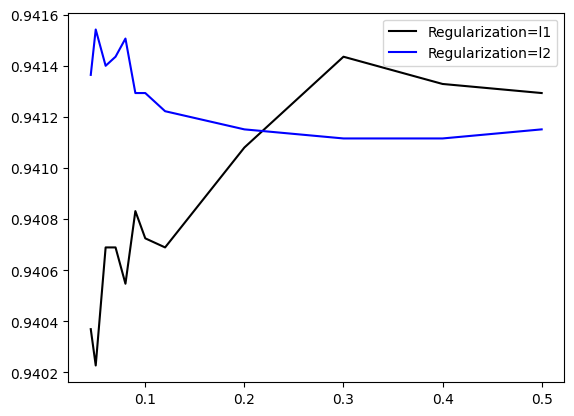

In [617]:
colors = ['black', 'blue']
l_values = ['l1', 'l2']

for l, col in zip(l_values, colors):
    df_subset = df_scores[df_scores.L == l]
    
    
    plt.plot(df_subset.C, df_subset.accuracy,
             color=col,
             label='Regularization=%s' % l)

plt.legend();

### Fine tuning with tree models

In [618]:
from tqdm import tqdm
scores = []

for n in tqdm(range(1,20, 2)):
    dt = DecisionTreeClassifier(max_depth=n, random_state=1)
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_val)
    y_predp = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_predp)
    accuracy=accuracy_score(y_val, y_pred)
    
    scores.append((n, auc, accuracy))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


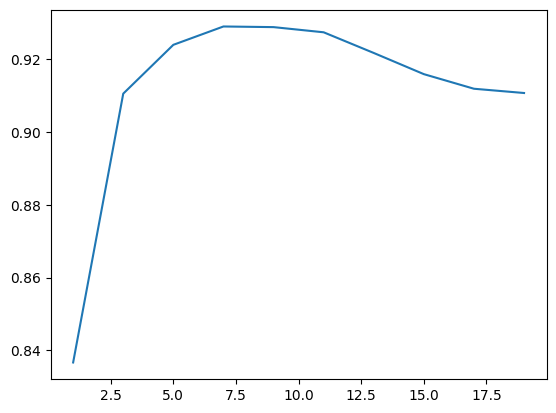

In [619]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'auc', 'accuracy'])
plt.plot(df_scores.max_depth, df_scores.accuracy) # top auc at estimator 160 to 180

In [630]:
from tqdm import tqdm
scores = []

for n in tqdm(range(50,100, 5)):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred=rf.predict(X_val)
    y_predp = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_predp)
    accuracy=accuracy=accuracy_score(y_val, y_pred)
    
    scores.append((n, auc, accuracy))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:29<00:00, 20.98s/it]


In [631]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc', 'accuracy'])

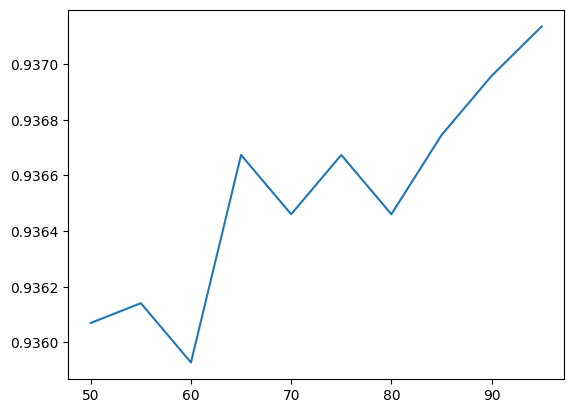

In [632]:
plt.plot(df_scores.n_estimators, df_scores.accuracy) # top auc at estimator 160 to 180

In [332]:
scores = []

for d in [5, 10, 15]:
    for n in range(150, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred=lr.predict(X_val)
        y_predp = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_predp)
        accuracy=accuracy=accuracy_score(y_val, y_pred)
        scores.append((d, n, auc, accuracy))

In [ ]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc', 'accuracy'])
plt.plot(df_scores.max_depth, df_scores.accuracy) # top auc at estimator 160 to 180

In [ ]:
test_dict=df_test[features].to_dict(orient='records')
X_test=dv.transform(test_dict)
y_pred=predict(X_test, LR)
accuracy_score(y_test, y_pred)

### Model Interpretation

In [190]:
lr.coef_[0].shape

(121,)

In [191]:
len(dv.get_feature_names())

AttributeError: 'DictVectorizer' object has no attribute 'get_feature_names'

In [206]:
dict(zip(dv.get_feature_names_out(), lr.coef_[0].round(3)))

{'academic-pressure': np.float64(0.852),
 'age': np.float64(-0.167),
 'cgpa': np.float64(0.07),
 'city=agra': np.float64(-0.176),
 'city=ahmedabad': np.float64(0.329),
 'city=bangalore': np.float64(-0.01),
 'city=bhopal': np.float64(0.029),
 'city=chennai': np.float64(-0.179),
 'city=delhi': np.float64(0.051),
 'city=faridabad': np.float64(-0.015),
 'city=ghaziabad': np.float64(0.157),
 'city=hyderabad': np.float64(0.285),
 'city=indore': np.float64(0.089),
 'city=jaipur': np.float64(-0.133),
 'city=kalyan': np.float64(0.083),
 'city=kanpur': np.float64(-0.117),
 'city=kolkata': np.float64(0.039),
 'city=lucknow': np.float64(0.017),
 'city=ludhiana': np.float64(-0.031),
 'city=meerut': np.float64(-0.096),
 'city=mumbai': np.float64(-0.371),
 'city=nagpur': np.float64(-0.279),
 'city=nashik': np.float64(0.09),
 'city=noise': np.float64(-0.249),
 'city=patna': np.float64(0.15),
 'city=pune': np.float64(-0.056),
 'city=rajkot': np.float64(0.026),
 'city=srinagar': np.float64(-0.044),
 'ci

## Submit

In [192]:
len(test)

93800

In [193]:
features,df_test_submit= preprocess(test)
df_test_submit.shape, len(features)

((93800, 19), 17)

In [197]:
df_test_submit.head(5)

,id,name,gender,age,city,working-professional-or-student,profession,academic-pressure,work-pressure,cgpa,study-satisfaction,job-satisfaction,sleep-duration,dietary-habits,degree,have-you-ever-had-suicidal-thoughts-?,work/study-hours,financial-stress,family-history-of-mental-illness
0,140700,shivam,male,53.0,visakhapatnam,working professional,judge,0.0,2.0,0.00,0.0,5.0,less than 5 hours,moderate,llb,no,9.0,3.0,yes
1,140701,sanya,female,58.0,kolkata,working professional,educational consultant,0.0,2.0,0.00,0.0,4.0,less than 5 hours,moderate,b.ed,no,6.0,4.0,no
2,140702,yash,male,53.0,jaipur,working professional,teacher,0.0,4.0,0.00,0.0,1.0,7-8 hours,moderate,b.arch,yes,12.0,4.0,no
3,140703,nalini,female,23.0,rajkot,student,missing,5.0,0.0,6.84,1.0,0.0,more than 8 hours,moderate,bsc,yes,10.0,4.0,no
4,140704,shaurya,male,47.0,kalyan,working professional,teacher,0.0,5.0,0.00,0.0,5.0,7-8 hours,moderate,bca,yes,3.0,4.0,no


In [308]:
lr=LogisticRegression(solver='liblinear', C=0.05, max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=0.05, max_iter=1000, random_state=42, solver='liblinear')

In [309]:
test_submit_dict=df_test_submit[features].to_dict(orient='records')
X_test_submit=dv.transform(test_submit_dict)
y_pred=predict(X_test_submit, LR)
y_pred[:5]

array([0, 0, 0, 1, 0])

In [310]:
submission=pd.read_csv('sample_submission.csv')

In [311]:
submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0


In [312]:
submission['Depression']=y_pred

In [313]:
submission.head(10)

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
5,140705,0
6,140706,0
7,140707,0
8,140708,0
9,140709,1


In [314]:
submission.Depression.value_counts(normalize=True)

Depression
0    0.824936
1    0.175064
Name: proportion, dtype: float64

In [315]:
submission.to_csv('sub3.csv', index=False)